# H2O ~ oo-pUCCD ~ prove di ottimizzazione

Determino l'initial point dei primi parametri del circuito $\ket{\text{pUCCD}}$ eseguendo una prima volta VQE. 
Dopodiché le alternative sono due:
- fissare i primi parametri e ottimizzare solo i $k$ orbitali
- ottimizzare ogni volta tutti i parametri

in questo programma si adotta la prima strategia. 
Il tempo di esecuzione è di circa 1 ora.

Per H2O è necessario congelare il primo orbitale.

In [43]:
from functools import partial 
from time import time
import matplotlib.pyplot as plt
from pyscf import gto, scf, fci

from subroutines import *

# Array distanze e energie
arr_distance = np.arange(0.55, 2.05, 0.15) 

# (0.55, 2.15, 0.15) così sono 10
# (0.40, 2.15, 0.35) così sono 5 punti

arr_ground_energy = {
    'FCI': [],
    'pUCCD': [],
    'oo-pUCCD': []
}
basis = 'sto3g'

arr_results = []
arr_partial_energies = []
arr_interpreted = []


# 5  punti ~ SLSQP(ftol=1E-03, eps=1.5E-06) ~ 6 min ~ alcuni punti (primo e ultimo) oo-puccd maggiori di puccd 
# 5  punti ~ SLSQP(ftol=1E-06, eps=1.5E-07) ~ 36min ~ però i risultati sono tornati belli
# 10 punti ~ SLSQP(ftol=1E-06, eps=1.5E-07) ~ 54min ~ però a 1.6 è compromesso


In [44]:
import math
from qiskit_nature.second_q.transformers import FreezeCoreTransformer

# punto di partenza degli optimizer
oo_starting_point = [ 9.77651956e-02, -1.19703685e-03,  1.01768167e-02,  9.53549115e-04,
                     -3.20438634e-05, -1.90954510e-02,  6.50714064e-02,  3.52356566e-03,
                      3.69306109e-03,  8.42263280e-03,  3.14384528e+00,  4.02826350e-03,
                      1.49454898e+00, -8.10752506e-04, -4.05248281e-02]
# t optimal point for d=0.7
puccd_starting_point = [ 3.17107572e+00, -3.14206458e+00,  3.13229639e+00,  3.24120168e+00,
                         3.42552905e+00, -3.14251495e+00,  5.94371343e+00,  8.63419212e-04]

from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
# scelta dell'optimizer
opt = SLSQP(ftol=1E-06, eps=1.5E-07)

for distance in arr_distance:
    # definisco un array per contenere le energie parziali a questa distanza
    par_en = []
    
    print('- - - - - - - - - - - -', distance, '- - - - - - - - - - - -')
    # 0: FCI
    # nell'articolo fissano l'angolo a 109.57° (invece di 104.5°)
    bond_angle = 109.57
    h = math.tan(bond_angle/2) * distance/2
    H2O = "H .0 .0 .0; O .0 " + str(h) + " " + str(distance) + "; H .0 .0 " + str(distance)

    mol = gto.M(
        atom=H2O,
        charge=0,
        spin=0,
        basis=basis,
        symmetry=True,
        verbose=0
    )
    # per ciascuna molecola calcolo il campo medio con restricted HF 
    cm  = scf.RHF(mol) # campo medio
    e_HF = cm.kernel() # questo va runnato a prescindere

    n_frozen_orbitals = 1 # per congelare il primo orbitale

    # per ciascuna molecola calcolo FCI
    fci_calc = fci.FCI(cm) # <- nei metodi correlati passiamo come argomento un conto di campo medio, HF
    e_FCI = fci_calc.kernel(frozen=n_frozen_orbitals)[0] # calcola FCI congelando n orbitali
    arr_ground_energy['FCI'].append(e_FCI)
    print('FCI: ', e_FCI)

    two_electron_integrals = mol.intor('int2e') # , aosym='s8') opzioni di simmetria
    one_electron_integrals = mol.intor("int1e_kin") + mol.intor("int1e_nuc")
    
    # avendo congelato il primo orbitale, vanno modificati gli integrali elettronici
    # è sufficiente escludere il primo indice in tutte le dimensioni:
    one_electron_integrals = one_electron_integrals[1:, 1:]
    two_electron_integrals = two_electron_integrals[1:, 1:, 1:, 1:]

    # 1: pUCCD
    problem = generate_problem(H2O, basis)
    # Freeze first orbital
    freezer = FreezeCoreTransformer(remove_orbitals=[0])
    problem = freezer.transform(problem)

    puccd = generate_puccd(problem)
    start_time = time()
    puccd_result = compute_puccd_optimal(puccd, problem, ini=puccd_starting_point, opt=opt) 
    eval_time  = time() - start_time 
    # store optimal point for next distance 
    puccd_starting_point = puccd_result.optimal_point
    # and assign parameters
    assigned_puccd = puccd.assign_parameters(puccd_result.optimal_parameters)
    puccd_interpreted = problem.interpret(puccd_result)
    shift = puccd_interpreted.extracted_transformer_energies.get("FreezeCoreTransformer", 0)
    puccd_energy = puccd_interpreted.groundenergy + puccd_interpreted.nuclear_repulsion_energy + shift
    arr_ground_energy['pUCCD'].append(puccd_energy)

    print('pUCCD: ', puccd_energy, ' | eval time: ', eval_time)

    # 2: oo-pUCCD
    rotations = create_orbital_rotation_list(puccd)
    excitations = convert_rotations_list(rotations)
    oo_puccd = generate_oo_puccd(assigned_puccd, problem, excitations)

    # SOLVE
    vqe_solver = VQE(Estimator(), oo_puccd, opt)

    energy_evaluation = partial(energy_evaluation_oo, 
                                problem, 
                                one_electron_integrals,
                                two_electron_integrals,
                                vqe_solver, 
                                rotations, 
                                0,
                                par_en)

    vqe_solver.initial_point = oo_starting_point

    # setto bounds default
    bounds = [ [-np.pi,np.pi] for _ in range(oo_puccd.num_parameters) ]

    print('Inizio minimizzazione')

    start_time = time()

    # minimization
    opt_result = vqe_solver.optimizer.minimize(
        fun=energy_evaluation, x0=ini, bounds=bounds
    )
        
    eval_time = time() - start_time

    result = VQEResult()
    result.optimal_point = opt_result.x
    result.optimal_parameters = dict(zip(vqe_solver.ansatz.parameters, opt_result.x))
    result.optimal_value = opt_result.fun
    result.cost_function_evals = opt_result.nfev
    result.optimizer_time = eval_time
    result.eigenvalue = opt_result.fun + 0j

    oo_interpreted = problem.interpret(result)
    shift = oo_interpreted.extracted_transformer_energies.get("FreezeCoreTransformer", 0)
    oo_energy = oo_interpreted.groundenergy + oo_interpreted.nuclear_repulsion_energy + shift

    arr_ground_energy['oo-pUCCD'].append(oo_energy)
    
    print('oo-pUCCD: ', oo_energy, ' | eval time: ', eval_time)
    
    # immagazzino tutto
    oo_starting_point = result.optimal_point
    starting_point = opt_result.x
    arr_results.append(result)
    arr_interpreted.append(oo_interpreted)
    arr_partial_energies.append(par_en)
    
    

- - - - - - - - - - - - 0.55 - - - - - - - - - - - -
FCI:  -74.80432652552804
pUCCD:  -74.75571599307138  | eval time:  17.912839889526367
Inizio minimizzazione


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_24621/2004780975.py:83: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE(Estimator(), oo_puccd, opt)


oo-pUCCD:  -74.770920278352  | eval time:  278.1886959075928
- - - - - - - - - - - - 0.7000000000000001 - - - - - - - - - - - -
FCI:  -74.91717639999031
pUCCD:  -74.83081176901878  | eval time:  17.17977809906006
Inizio minimizzazione
oo-pUCCD:  -74.88918412504485  | eval time:  54.04451274871826
- - - - - - - - - - - - 0.8500000000000001 - - - - - - - - - - - -
FCI:  -74.92727508061971
pUCCD:  -74.83340282516403  | eval time:  21.959525108337402
Inizio minimizzazione
oo-pUCCD:  -74.90042330302552  | eval time:  137.44212818145752
- - - - - - - - - - - - 1.0 - - - - - - - - - - - -
FCI:  -74.904294630134
pUCCD:  -74.80910914030187  | eval time:  21.854270935058594
Inizio minimizzazione
oo-pUCCD:  -74.87745308477264  | eval time:  122.49148321151733
- - - - - - - - - - - - 1.1500000000000001 - - - - - - - - - - - -
FCI:  -74.87193995706308
pUCCD:  -74.77645183465827  | eval time:  28.66033697128296
Inizio minimizzazione
oo-pUCCD:  -74.86483242193799  | eval time:  119.52416682243347
- -

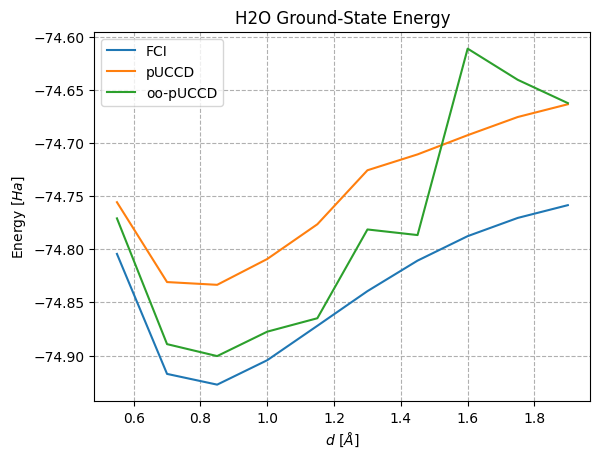

In [45]:
    
method = ['FCI', 'pUCCD', 'oo-pUCCD']

for met in method:  
    plt.plot(arr_distance, arr_ground_energy[met], label=met)

plt.title("H2O Ground-State Energy")
plt.xlabel(r"$d$ $[\AA]$")
plt.ylabel(r"Energy $[Ha]$")
plt.grid(linestyle='--')
plt.legend()
plt.show()

In [62]:
print(arr_distance[7])

1.6


# Grafico convergenza

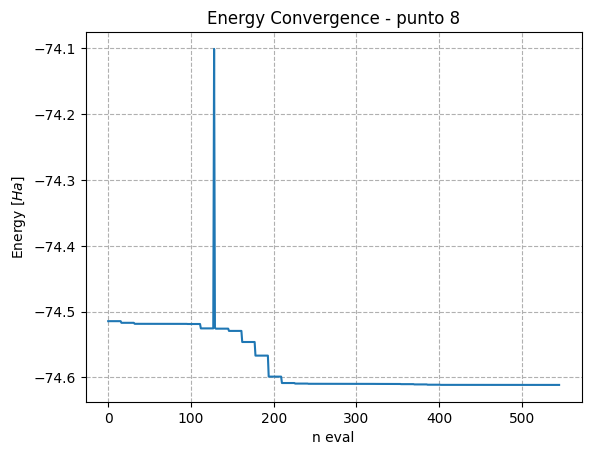

In [63]:
# shifto le energie parziali con nuclear repulsion
repulsion = arr_interpreted[7].nuclear_repulsion_energy
frozen_core = arr_interpreted[7].extracted_transformer_energies.get("FreezeCoreTransformer", 0)

shiftato = [x + repulsion + frozen_core for x in arr_partial_energies[7]]

plt.plot(range(len(arr_partial_energies[7])), shiftato)

plt.title("Energy Convergence - punto 8")
plt.xlabel(r"n eval")
plt.ylabel(r"Energy $[Ha]$")
plt.grid(linestyle='--')
#plt.legend()
plt.show()